In [1]:
import platform
import warnings

# For warnings in xgboost.sklearn
warnings.simplefilter(action="ignore", category=FutureWarning)

import time

import matplotlib.pyplot as plt
import numpy
from matplotlib.colors import ListedColormap
from sklearn.datasets import fetch_openml, make_circles
from sklearn.ensemble import RandomForestClassifier as SklearnRandomForestClassifier
from sklearn import metrics
from sklearn.metrics import make_scorer, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost.sklearn import XGBClassifier as SklearnXGBClassifier
import xgboost

import concrete
from concrete.ml.sklearn import RandomForestClassifier as ConcreteRandomForestClassifier
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm

%matplotlib inline

/home/vialla/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/vialla/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
concrete.ml.__version__

'0.3.0'

Intel(R) Core(TM) i7-9800X CPU @ 3.80GHz 8 cores, RAM 32 Go, WSL2 Windows 11

In [3]:
SEED = 0

In [4]:
df = pd.read_csv('../data/train_feats.csv').sample(frac=1, random_state=SEED)

In [5]:
df.shape

(12670818, 10)

In [6]:
feats = ['feat'+str(i+1) for i in range(9)]

In [7]:
val_size = int(0.15*len(df))
val_size

1900622

In [8]:
X_train, y_train = df[:-val_size][feats].values, df[:-val_size]['label'].values
X_valid, y_valid = df[-val_size:][feats].values, df[-val_size:]['label'].values

In [9]:
X_train.shape, X_valid.shape

((10770196, 9), (1900622, 9))

In [10]:
X_train_concrete, y_train_concrete = X_train[:2_000_000], y_train[:2_000_000] # <- if more than 2 000 0000 elements
X_valid_concrete, y_valid_concrete = X_valid, y_valid

In [11]:
def plot_roc_curve(data, thresholds = None):
    plt.figure()
    for k, v in data.items():
        plt.plot(v['fp'], v['tp'] , label=f'{k} (area = %0.4f)' % metrics.auc(v['fp'], v['tp']))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    if len(data) == 1 and thresholds is not None:
        ax2 = plt.gca().twinx()
        ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
        ax2.set_ylabel('Threshold',color='r')
        ax2.set_ylim([thresholds[-1],thresholds[0]])
        ax2.set_xlim([fpr[0],fpr[-1]])

    plt.savefig('roc_and_threshold.png')
    return plt

## XGboost

In [12]:
sklearn_clf = SklearnXGBClassifier(n_estimators=250, max_depth=3,
                                 n_jobs=-1, eval_metric='auc',
                                 early_stopping_rounds=25)

In [13]:
sklearn_clf.fit(X=X_train, y=y_train, eval_set=[(X_valid_concrete, y_valid_concrete)])

[0]	validation_0-auc:0.94293
[1]	validation_0-auc:0.95368
[2]	validation_0-auc:0.95704
[3]	validation_0-auc:0.95941
[4]	validation_0-auc:0.96116
[5]	validation_0-auc:0.96211
[6]	validation_0-auc:0.96444
[7]	validation_0-auc:0.96515
[8]	validation_0-auc:0.96637
[9]	validation_0-auc:0.96737
[10]	validation_0-auc:0.96863
[11]	validation_0-auc:0.96951
[12]	validation_0-auc:0.97000
[13]	validation_0-auc:0.97062
[14]	validation_0-auc:0.97134
[15]	validation_0-auc:0.97174
[16]	validation_0-auc:0.97264
[17]	validation_0-auc:0.97290
[18]	validation_0-auc:0.97375
[19]	validation_0-auc:0.97451
[20]	validation_0-auc:0.97483
[21]	validation_0-auc:0.97581
[22]	validation_0-auc:0.97597
[23]	validation_0-auc:0.97612
[24]	validation_0-auc:0.97635
[25]	validation_0-auc:0.97691
[26]	validation_0-auc:0.97727
[27]	validation_0-auc:0.97733
[28]	validation_0-auc:0.97754
[29]	validation_0-auc:0.97764
[30]	validation_0-auc:0.97776
[31]	validation_0-auc:0.97803
[32]	validation_0-auc:0.97857
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=25, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=250,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [14]:
res_xgboost = {}
y_preds = sklearn_clf.predict_proba(X_valid_concrete)[:,1]
fpr, tpr, _ = roc_curve(y_valid_concrete, y_preds)
res_xgboost = {'fp':fpr, 'tp':tpr}

## Concrete 

### n_bits

In [15]:
res = {}
for n_bits in tqdm([5, 6, 7, 8]):
    concrete_clf = ConcreteXGBClassifier(n_jobs=-1, max_depth=2,  n_estimators=25, n_bits=n_bits)
    concrete_clf.fit(X=X_train_concrete, y=y_train_concrete)
    y_preds = concrete_clf.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, y_preds)
    res[f'nbits_{n_bits}'] = {'fp':fpr, 'tp':tpr}

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
res['xgboost_baseline'] = res_xgboost

<module 'matplotlib.pyplot' from '/home/vialla/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

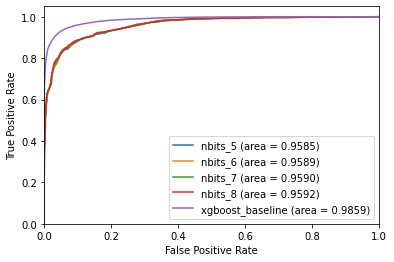

In [17]:
plot_roc_curve(res)

## max_depth

In [18]:
res = {}
for max_depth in tqdm([2, 3]): # 4, 5 <- memory error, process killed by system 
    concrete_clf = ConcreteXGBClassifier(n_jobs=-1, max_depth=max_depth,  n_estimators=25, n_bits=5)
    concrete_clf.fit(X=X_train_concrete, y=y_train_concrete)
    y_preds = concrete_clf.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, y_preds)
    res[f'max_depth_{max_depth}'] = {'fp':fpr, 'tp':tpr}

  0%|          | 0/2 [00:00<?, ?it/s]

In [19]:
res['xgboost_baseline'] = res_xgboost

<module 'matplotlib.pyplot' from '/home/vialla/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

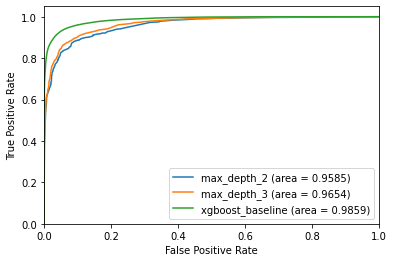

In [20]:
plot_roc_curve(res)

## n_estimators

In [21]:
res = {}
for n_estimators in tqdm([10, 25, 50, 75]): # 100, 250 <- memory error, process killed
    concrete_clf = ConcreteXGBClassifier(n_jobs=-1, max_depth=2,  n_estimators=n_estimators, n_bits=5)
    concrete_clf.fit(X=X_train_concrete, y=y_train_concrete)
    y_preds = concrete_clf.predict_proba(X_valid)[:,1]
    fpr, tpr, _ = roc_curve(y_valid, y_preds)
    res[f'n_estim_{n_estimators}'] = {'fp':fpr, 'tp':tpr}

  0%|          | 0/4 [00:00<?, ?it/s]

In [22]:
res['xgboost_baseline'] = res_xgboost

<module 'matplotlib.pyplot' from '/home/vialla/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

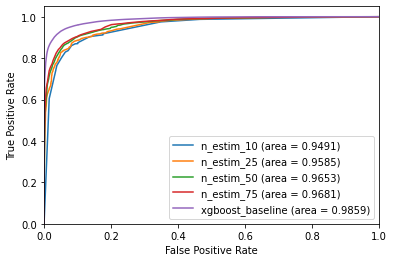

In [23]:
plot_roc_curve(res)